# Generate Synthetic Dataset

In [7]:
# !pip install -U git+https://github.com/scikit-multiflow/scikit-multiflow
# !pip install scikit-multiflow

In [15]:
import skmultiflow
from skmultiflow.data.base_stream import Stream
from skmultiflow.utils import check_random_state
from skmultiflow.data import ConceptDriftStream
from skmultiflow.data.regression_generator import RegressionGenerator
import matplotlib.pyplot as plt
import random
import numpy as np
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter

In [143]:
def generate_data(num_drifts, number_datapoints, drift_position, seed, recurrent, filtering,
                  exaggerate):
    """
    Generates simulated data with concept drifts.

    Parameters
    ----------
    num_drifts : int
        The number of concept drifts to simulate.
    number_datapoints : int
        The number of data points to generate for each drift.
    seed : int
        The random seed to use for generating the data.
    recurrent : bool
        Whether to generate recurrent data (i.e., where the inputs depend on previous outputs).
    filtering : str
        The type of filtering to apply to the output data. Options are "median", "gaussian", or None.
    exaggerate : int
        Whether each stream should be multiplied by a constant such that the difference between drifts
        are exagerrated.

    Returns
    -------
    X : numpy.ndarray, shape (n_samples, n_features)
        The input data.
    y : numpy.ndarray, shape (n_samples,)
        The output data.
    data_index : list
        The index of each data point in the generated stream.

    """
    
    data = []
    for i in range(num_drifts-1):
        
        # if recurrent concept drift then set seed in one of the two streams to same
        first_stream_seed = seed if recurrent else random.randint(0, 100)
        
        # Generate a stream object with concept drift
        stream_output_object = skmultiflow.data.ConceptDriftStream(stream=RegressionGenerator(
                                                            n_samples=number_datapoints,
                                                            n_features=20,
                                                            n_targets=1,
                                                            n_informative=6,
                                                            random_state=first_stream_seed),
                                        drift_stream=RegressionGenerator(
                                                             n_samples=number_datapoints,
                                                             n_features=20,
                                                             n_targets=1,
                                                             n_informative=6,
                                                             random_state=random.randint(0, 100)), 
                                                position=drift_position, width=1,
                                                random_state=seed, alpha=0.0)
        # Generate data for the stream object
        data_i = stream_output_object.next_sample(number_datapoints)
        
        # Apply filtering to the output data if requested
        if filtering == "median":
            # median filtering
            y = medfilt(list(data_i[1]))

        elif filtering == "gaussian":
            # Gaussian filter
            y = gaussian_filter(list(data_i[1]), sigma=1)

        else:
            y = data_i[1]
        
        # exaggerate size of concept drift
        if np.random.choice([True, False]) and exaggerate != None:
            y = y * random.randint(-5, 5)
            
        # Reshape the output data and add it to the list of generated data
        y = np.reshape(y, (number_datapoints, 1))
        data.append((data_i[0], y, list(range(i*number_datapoints+1, (i+1)*number_datapoints+1))))
    
    # Concatenate the generated data and return it
    X = np.concatenate([d[0] for d in data])
    y = np.concatenate([d[1] for d in data]).ravel()
    data_index = np.concatenate([d[2] for d in data])
    
    print("Shape features " + str(X.shape))
    print("Shape target " + str(y.shape))
    
    def print_means(y, drift_position):
        index = 1
        start = 0
        end = drift_position
        for i in range(3+1):
            print("Mean " + str(index) + ": " + str(y[start:end].mean()))
            index += 1
            start += 500
            end += 500

    print_means(y, drift_position)

    return X,y, data_index

In [145]:
# generate data
X,y, data_index = generate_data(num_drifts = 6, 
                                number_datapoints = 1000,
                                drift_position = 500,
                                seed = 42,
                                recurrent = True,
                                filtering = None,
                                exaggerate = 5)  

Shape features (5000, 20)
Shape target (5000,)
Mean 1: -11.38688278213554
Mean 2: 29.31590123404484
Mean 3: 2.846720695533885
Mean 4: 8.830450034040966


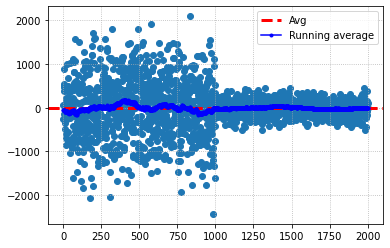

In [119]:
def plot_avg_ravg(data_index, y, window_size):
    plt.scatter(data_index, y)

    #add horizontal line at mean value of y
    plt.axhline(y=np.nanmean(y), color='red', linestyle='--', linewidth=3, label='Avg')

    # running average
    window = window_size
    average_y = []
    for ind in range(len(y) - window + 1):
        average_y.append(np.mean(y[ind:ind+window]))
    # make y have the same length as x
    if len(average_y) < len(data_index):
        average_y = np.append(average_y, [average_y[-1]] * (len(data_index) - len(average_y)))

    plt.plot(data_index, average_y, 'b.-', label='Running average')
    plt.grid(linestyle=':')
    plt.legend()
    plt.show()

plot_avg_ravg(data_index, y, window_size = 100)